#**Transfer pembelajaran dengan TensorFlow Hub**

Dalam project ini, saya mencoba mengklasifikasikan gambar dengan menggunakan pembelajaran transfer dari jaringan yang telah dilatih sebelumnya.

Intuisi di balik pembelajaran transfer untuk klasifikasi gambar adalah bahwa jika model dilatih pada kumpulan data yang cukup besar dan umum, model ini akan secara efektif berfungsi sebagai model umum dunia visual. Kemudian dapat memanfaatkan peta fitur yang dipelajari ini tanpa harus memulai dari awal dengan melatih model besar pada kumpulan data yang besar.

Kemudian akan mencoba dua cara untuk menyesuaikan model yang sudah dilatih sebelumnya :
1. Ekstraksi fitur,  representasi yang dipelajari oleh jaringan sebelumnya untuk mengekstrak fitur yang berarti dari sampel baru
2. Fine-Tuning, Mencairkan beberapa lapisan atas dari basis model yang dibekukan dan bersama-sama melatih lapisan pengklasifikasi yang baru ditambahkan dan lapisan terakhir dari model dasar

In [1]:
# Pra-pemrosesan data

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
# Mengunduh dataset

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
# Validation dataset

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


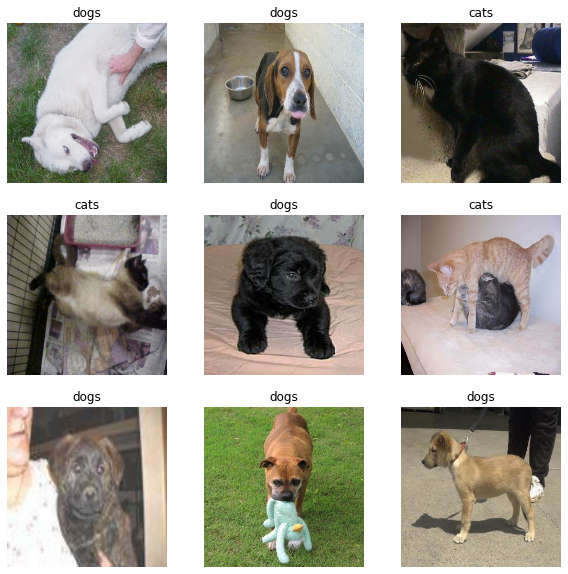

In [4]:
# Show image

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Karena set data asli tidak berisi set pengujian. Untuk melakukannya, tentukan berapa banyak kumpulan data yang tersedia di set validasi menggunakan tf.data.experimental.cardinality , lalu pindahkan 20% darinya ke set pengujian.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


#**Konfigurasi kumpulan data pada dataset**

Gunakan buffered prefetching untuk memuat gambar dari disk tanpa I/O menjadi pemblokiran

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#**Menggunakan augmentasi data**

Menggunakan augmentasi data merupakan teknik untuk meningkatkan keragaman set pelatihan dengan menerapkan transformasi acak (namun realistis)

In [8]:
# Augmentation of data

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Mengulang kembali untuk menerapkan lapisan gambar yang sama dan melihat hasilnya 

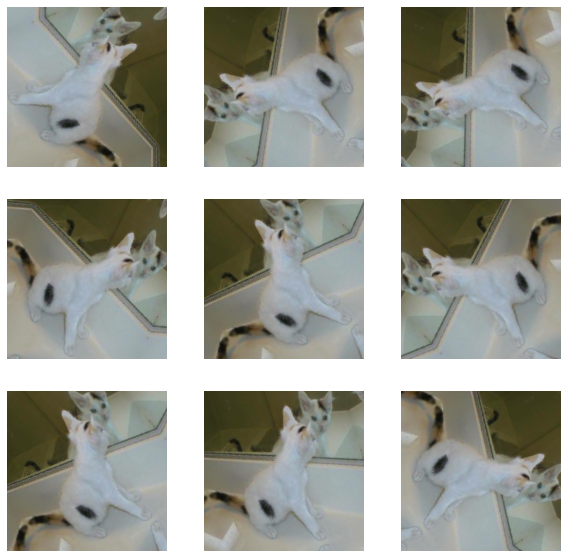

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Mengulang nilai pixel pada gambat diatas

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# **Membuat model dasar dari Konvnet yang telah dilatih sebelumnya**

Pertama, buat instance model MobileNet V2 yang telah dimuat sebelumnya dengan bobot yang dilatih di ImageNet. Dengan menentukan argumen include_top=False , Saya memuat jaringan yang tidak menyertakan lapisan klasifikasi di bagian atas, yang ideal untuk ekstraksi fitur.

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


Ekstraktor fitur ini mengubah setiap gambar 160x160x3 menjadi blok fitur 5x5x1280 . Mari kita lihat apa yang dilakukannya pada kumpulan contoh gambar:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# **Ekstraksi fitur**

Pada langkah ini, kita akan membekukan basis konvolusi yang dibuat dari langkah sebelumnya dan untuk digunakan sebagai ekstraktor fitur. Selain itu, kita menambahkan pengklasifikasi di atasnya dan melatih pengklasifikasi tingkat atas.

In [14]:
# Bekukan basis konvolusi

base_model.trainable = False

Penting untuk membekukan basis konvolusi sebelum kita mengompilasi dan melatih model. Pembekuan (dengan menyetel layer.trainable = False) mencegah pembobotan pada layer tertentu agar tidak diperbarui selama pelatihan. MobileNet V2 memiliki banyak lapisan, jadi menyetel seluruh flag yang trainable untuk model ke False akan membekukan semuanya

# **Menggunakan lapisan Batch Normalization**

In [15]:
# Let's take a look at the base model architecture

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

# **Menambahkan kepala klasifikasi**

Untuk menghasilkan prediksi dari blok fitur, rata-ratakan lokasi spasial 5x5 spasial, menggunakan lapisan tf.keras.layers.GlobalAveragePooling2D untuk mengonversi fitur menjadi satu vektor 1280 elemen per gambar.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Terapkan lapisan tf.keras.layers.Dense untuk mengonversi fitur ini menjadi satu prediksi per gambar. Kita tidak memerlukan fungsi aktivasi di sini karena prediksi ini akan diperlakukan sebagai logit , atau nilai prediksi mentah. Angka positif memprediksi kelas 1, angka negatif memprediksi kelas 0.

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Bangun model dengan menyatukan lapisan augmentasi data, penskalaan ulang, base_model , dan ekstraktor fitur menggunakan Keras Functional API . Seperti yang disebutkan sebelumnya, gunakan training=False karena model kami berisi lapisan BatchNormalization .

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# **Kompilasi modelnya**

Kompilasi model sebelum melatihnya. Karena ada dua kelas, gunakan kerugian tf.keras.losses.BinaryCrossentropy dengan from_logits=True karena model menyediakan output linier.

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

2,5 juta parameter di MobileNet dibekukan, tetapi ada 1,2 ribu parameter yang dapat dilatih di lapisan Padat. Ini dibagi antara dua objek tf.Variable , bobot dan bias.

In [21]:
len(model.trainable_variables)

2

# **Melatih modelnya**

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 13s 432ms/step - loss: 0.7457 - accuracy: 0.5396


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.54


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 46s 674ms/step - loss: 0.6955 - accuracy: 0.5960 - val_loss: 0.5030 - val_accuracy: 0.6918
Epoch 2/10
63/63 [==============================] - 44s 694ms/step - loss: 0.5213 - accuracy: 0.7090 - val_loss: 0.3797 - val_accuracy: 0.7983
Epoch 3/10
63/63 [==============================] - 44s 699ms/step - loss: 0.4177 - accuracy: 0.7845 - val_loss: 0.3025 - val_accuracy: 0.8453
Epoch 4/10
63/63 [==============================] - 44s 696ms/step - loss: 0.3649 - accuracy: 0.8100 - val_loss: 0.2528 - val_accuracy: 0.8886
Epoch 5/10
63/63 [==============================] - 43s 680ms/step - loss: 0.3256 - accuracy: 0.8475 - val_loss: 0.2122 - val_accuracy: 0.9121
Epoch 6/10
63/63 [==============================] - 43s 678ms/step - loss: 0.2960 - accuracy: 0.8620 - val_loss: 0.1894 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 43s 685ms/step - loss: 0.2637 - accuracy: 0.8740 - val_loss: 0.1682 - val_accuracy: 0.9319

# **Show kurva belajar**

Mari kita lihat kurva pembelajaran dari pelatihan dan akurasi/kerugian validasi saat menggunakan model dasar MobileNetV2 sebagai ekstraktor fitur tetap.

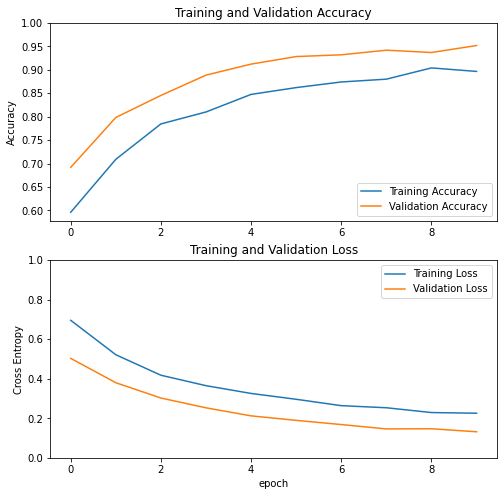

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Mencari setelan**

Dalam eksperimen ekstraksi fitur, Kita hanya melatih beberapa lapisan di atas model dasar MobileNetV2. Bobot jaringan pra-terlatih tidak diperbarui selama pelatihan.

Salah satu cara untuk meningkatkan performa lebih jauh lagi adalah dengan melatih (atau "menyesuaikan") bobot lapisan atas model yang telah dilatih sebelumnya di samping pelatihan pengklasifikasi yang Kita tambahkan. Proses pelatihan akan memaksa bobot untuk disetel dari peta fitur umum ke fitur yang terkait secara khusus dengan kumpulan data.

Selain itu, Kita harus mencoba menyempurnakan sejumlah kecil lapisan atas daripada keseluruhan model MobileNet. Di sebagian besar jaringan konvolusi, semakin tinggi lapisannya, semakin terspesialisasi. Beberapa lapisan pertama mempelajari fitur yang sangat sederhana dan umum yang digeneralisasikan ke hampir semua jenis gambar. Saat kita naik lebih tinggi, fitur-fiturnya semakin spesifik untuk kumpulan data tempat model dilatih. Tujuan fine-tuning adalah untuk mengadaptasi fitur-fitur khusus ini untuk bekerja dengan dataset baru, daripada menimpa pembelajaran generik.

Un-freeze lapisan atas model

Yang perlu Anda lakukan adalah mencairkan base_model dan mengatur lapisan bawah agar tidak dapat dilatih. Kemudian, Anda harus mengkompilasi ulang model (diperlukan agar perubahan ini diterapkan), dan melanjutkan pelatihan.

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


# **Kompilasi Modelnya**

Saat kita melatih model yang jauh lebih besar dan ingin menyesuaikan kembali bobot yang telah dilatih sebelumnya, penting untuk menggunakan tingkat pembelajaran yang lebih rendah pada tahap ini. Jika tidak, model Anda bisa overfit dengan sangat cepat.

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
# Panjang model

len(model.trainable_variables)

56

# **Melanjutkan melatih model**

Jika kita dilatih untuk konvergensi sebelumnya, langkah ini akan meningkatkan akurasi kita dengan beberapa poin persentase.

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 73s 1s/step - loss: 0.1692 - accuracy: 0.9295 - val_loss: 0.0609 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 68s 1s/step - loss: 0.1299 - accuracy: 0.9435 - val_loss: 0.0498 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 66s 1s/step - loss: 0.1091 - accuracy: 0.9580 - val_loss: 0.0414 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 66s 1s/step - loss: 0.0926 - accuracy: 0.9620 - val_loss: 0.0435 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 66s 1s/step - loss: 0.0942 - accuracy: 0.9610 - val_loss: 0.0399 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 65s 1s/step - loss: 0.0860 - accuracy: 0.9635 - val_loss: 0.0363 - val_accuracy: 0.9839
Epoch 16/20
63/63 [==============================] - 65s 1s/step - loss: 0.0721 - accuracy: 0.9725 - val_loss: 0.0427 - val_accuracy: 0.9790
Epoch 17/20
6

Mari kita lihat kurva pembelajaran dari pelatihan dan akurasi/kerugian validasi saat menyempurnakan beberapa lapisan terakhir model dasar MobileNetV2 dan melatih pengklasifikasi di atasnya. Kehilangan validasi jauh lebih tinggi daripada kerugian pelatihan, jadi Kita mungkin mendapatkan beberapa overfitting.

Kita juga mungkin mendapatkan beberapa overfitting karena set pelatihan baru relatif kecil dan mirip dengan set data MobileNetV2 asli.

Setelah fine tuning, model hampir mencapai akurasi 98% pada set validasi.

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

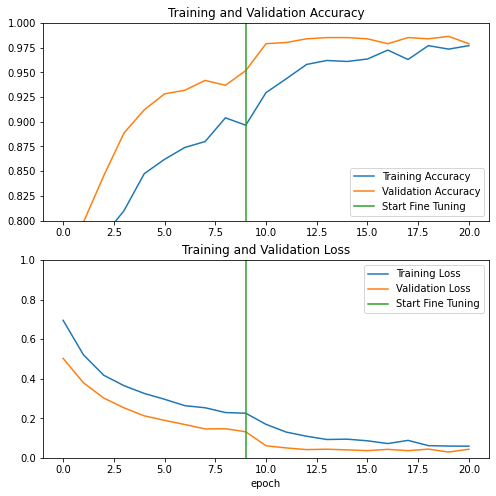

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Evaluasi dan Prediksi**

Akhirnya Kitaa dapat memverifikasi kinerja model pada data baru menggunakan test set.

In [34]:
# Function loss

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 427ms/step - loss: 0.0297 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Dan sekarang Kita siap menggunakan model ini untuk memprediksi apakah hewan peliharaan Kamu adalah kucing atau anjing.

Predictions:
 [0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1]
Labels:
 [0 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1]


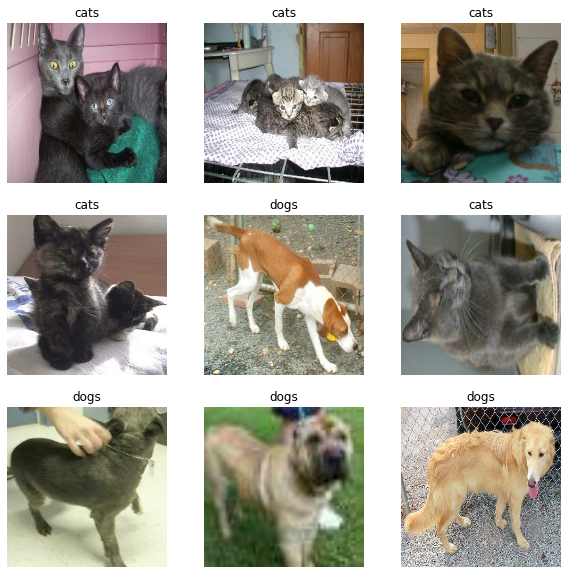

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# **Ringkasan**

**Menggunakan model yang telah dilatih sebelumnya untuk ekstraksi fitur** : Saat bekerja dengan kumpulan data kecil, merupakan praktik umum untuk memanfaatkan fitur yang dipelajari oleh model yang dilatih pada kumpulan data yang lebih besar dalam domain yang sama. Ini dilakukan dengan membuat instance model yang telah dilatih sebelumnya dan menambahkan classifier yang terhubung penuh di atasnya. Model pra-pelatihan "dibekukan" dan hanya bobot pengklasifikasi yang diperbarui selama pelatihan. Dalam hal ini, basis konvolusi mengekstrak semua fitur yang terkait dengan setiap gambar dan Anda baru saja melatih pengklasifikasi yang menentukan kelas gambar yang diberikan kumpulan fitur yang diekstraksi.

**Menyesuaikan model yang telah dilatih sebelumnya** : Untuk lebih meningkatkan kinerja, seseorang mungkin ingin menggunakan kembali lapisan tingkat atas dari model yang telah dilatih sebelumnya ke kumpulan data baru melalui penyetelan halus. Dalam hal ini, Anda menyetel bobot Anda sedemikian rupa sehingga model Anda mempelajari fitur tingkat tinggi khusus untuk kumpulan data. Teknik ini biasanya direkomendasikan ketika dataset pelatihan besar dan sangat mirip dengan dataset asli yang digunakan untuk melatih model pra-pelatihan.